In [93]:
import pandas as pd
import numpy as np

from itertools import combinations
from catboost import CatBoostClassifier

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv("data/test.csv")

### 1. Preparation

In [94]:
train_df.fillna(-999, inplace=True)
test_df.fillna(-999, inplace=True)
y = train_df.pop('Survived')

Find categorical feature indexes

In [95]:
print(train_df.dtypes)
categorical_features_indices = np.where(train_df.dtypes != float)[0]

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Analyze label values to understand balance in binary target

In [96]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y)-sum(y), sum(y)))

Labels: {0, 1}
Zero count = 549, One count = 342


### 2. Model training

The model was trained using a gradient boosting classifier, with a specific focus on reducing variance through the use of bagging. The process began by splitting the data into a training and testing set.

Next, an object of the gradient boosting classifier was created and the model was fit to the matrix of features (X) and vector of labels (y). The categorical feature indexes were also passed as a parameter during the fitting process. The model was initially set to be trained on an ensemble of 1500 trees. 

The model was then trained on the training set using early stopping with an evaluation set. This helped to ensure that the model was not overfitting and that the best results were being achieved.

The results were then cross-validated to ensure that they were reliable. The objective function was also selected as Logloss (options include: Logloss for binary target, CrossEntropy for probabilities in the target, and Multiclass for multiple class target.). Early stopping was used for logloss, but could be optimized for other metrics such as AUC.

Two ways of training the ensemble can be employed:

* The learning rate is not set and the model is allowed to find the best learning rate for the number of trees specified. This method was expected to result in overfitting at the end.

* The learning rate is set (such as 0.03), the model is trained for many iterations (such as 10,000), and an overfitting detector is used as it aims to return the best number of trees.

In [97]:
from sklearn.model_selection import train_test_split
from catboost import Pool # a different way of passing in the dataset
from sklearn.metrics import accuracy_score

data = train_test_split(train_df, y, test_size=0.2, stratify=y ,random_state=4)
X_train, X_val, y_train, y_val = data

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=categorical_features_indices
)

validation_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features=categorical_features_indices
)

In [98]:
clf = CatBoostClassifier(
    iterations= 1500, # normally  until stops decreasing both errors (like 5000)
    learning_rate=0.03, # automatically sets learning rate according to dataset size and number of trees
    depth = 10, #try 10
    loss_function= 'Logloss',
    custom_loss=['AUC', "Accuracy"],
    early_stopping_rounds=20
)

clf.fit(
    train_pool, 
    eval_set=validation_pool,
    #eval_metric='AUC', # to optimize for other metric set eval metric . 
    verbose=100,
    plot=True
)

print('Model is fitted {}'.format(clf.is_fitted()))
print('Model params:\n{}'.format(clf.get_params()))
print('Model scores: {}'.format(clf.best_score_))
print('Model tree count: {}'.format(clf.tree_count_))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6763253	test: 0.6772445	best: 0.6772445 (0)	total: 19.9ms	remaining: 29.8s
100:	learn: 0.2994713	test: 0.4165038	best: 0.4163479 (92)	total: 5.38s	remaining: 1m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.4094948727
bestIteration = 166

Shrink model to first 167 iterations.
Model is fitted True
Model params:
{'iterations': 1500, 'learning_rate': 0.03, 'depth': 10, 'loss_function': 'Logloss', 'custom_loss': ['AUC', 'Accuracy'], 'early_stopping_rounds': 20}
Model scores: {'learn': {'Accuracy': 0.922752808988764, 'Logloss': 0.24286642146814783}, 'validation': {'Accuracy': 0.8324022346368715, 'Logloss': 0.4094948727254779, 'AUC': 0.8759552042160738}}
Model tree count: 167


Cross validate the results on validation pool

In [99]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 167,
    'custom_loss': 'AUC',
    'learning_rate':  0.039393
}

cv_data = cv(
    params=params,
    pool=validation_pool,
    fold_count = 5,  # -> by default its stratified cross validation
    shuffle = True,
    partition_random_seed=0,
    plot=True,
    verbose=False,
    #stratified=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.6473759473
bestIteration = 7

Training on fold [1/5]

bestTest = 0.4469536284
bestIteration = 140

Training on fold [2/5]

bestTest = 0.3813610686
bestIteration = 155

Training on fold [3/5]

bestTest = 0.3713649086
bestIteration = 160

Training on fold [4/5]

bestTest = 0.4426779487
bestIteration = 113



In [100]:
cv_data.head(10)

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.675824,0.006488,0.671322,0.005630,0.754421,0.116514
1,1,0.658952,0.007575,0.651575,0.011432,0.774550,0.075991
2,2,0.644284,0.011687,0.630012,0.011891,0.796903,0.081851
3,3,0.633162,0.015746,0.614912,0.011578,0.799301,0.083481
4,4,0.623344,0.020397,0.603307,0.013480,0.815210,0.098287
5,5,0.612187,0.026319,0.588554,0.013737,0.806868,0.120012
6,6,0.602789,0.028562,0.575641,0.015784,0.803771,0.119515
7,7,0.594671,0.031180,0.563595,0.016426,0.803397,0.104774
8,8,0.585859,0.038787,0.551369,0.018642,0.799226,0.131370
9,9,0.577092,0.043134,0.539515,0.019348,0.801623,0.130500


#### Hyperparameter tuning

Tuning the hyperparameters of a machine learning model is essential to achieving optimal performance. One of the most important parameters to tune is the learning rate in conjunction with the number of iterations. This is done automatically by catboost algorithm. In particular, when using logloss as the evaluation metric, the best point should be close to the end of the graph, but not at the very end, as this would indicate underfitting. It is desirable for the model to overfit a little bit.

Another important parameter to consider is the depth of the tree. When using catboost, a symmetric binary tree, it's recommended to start with a depth of 6 and adjust to 8 or 12 if it works well, but if it doesn't work, trying to go deeper would cause extreme overfitting as the number of leafs would be 2 to the power of 16.

The tree growing strategy is also an important factor to consider. The three main options are:

* full binary symmetric, which is recommended for noisy data
* depthwise, which splits the tree one level at a time and is less computationally expensive but may result in a suboptimal split
* lossguide, which splits the tree based on the reduction in the loss function, works well for onehot encoding, simulated data without noise.

Other parameters such as l2_leaf_reg, random_strength and bagging_temperature are also worth experimenting with but no specific recommendations can be made. It's important to try different combinations of these parameters to find the best fit for the specific dataset and problem at hand.

In [101]:
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution

param_distributions = {
    "learning_rate": FloatDistribution(0.03, 0.045),
    'iterations': IntDistribution(160, 175),
    'l2_leaf_reg': FloatDistribution(1e-6, 100, log=True),
    'random_strength': FloatDistribution(1e-6, 100, log=True),
    'bagging_temperature': FloatDistribution(1e-6, 100, log=True),
}

clf = CatBoostClassifier(
    #iterations=100, #enseble of 100 trees
    loss_function='Logloss',
    custom_loss='AUC',
    cat_features=categorical_features_indices, 
    verbose=False
)

optuna_search = OptunaSearchCV(
    clf, 
    param_distributions, 
    cv=5, # seit liec stratified
    verbose=10,
    n_trials=10
    )

results = optuna_search.fit(X_train, y_train)
results.best_estimator_.get_params()

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-01-24 16:20:02,072] A new study created in memory with name: no-name-0c8d1cc6-d0e5-4f2e-aa28-e1d66471ab94
[I 2023-01-24 16:20:02,075] Searching the best hyperparameters using 712 samples...
[I 2023-01-24 16:20:25,156] Trial 0 finished with value: 0.825844577957254 and parameters: {'learning_rate': 0.032079909388971324, 'iterations': 174, 'l2_leaf_reg': 0.005737121785848819, 'random_strength': 0.0024205397082330557, 'bagging_temperature': 11.783716259986619}. Best is trial 0 with value: 0.825844577957254.
[I 2023-01-24 16:20:47,100] Trial 1 finished with value: 0.8258051807347583 and parameters: {'learning_rate': 0.043005244427715084, 'iterations': 165, 'l2_leaf_reg': 0.0009891411833044983, 'random_strength': 9.07183202672916e-05, 'bagging_temperature': 16.807453628859236}. Best is trial 0 with value: 0.825844577957254.
[I 2023-01-24 16:21:11,818] Trial 2 finished with value: 0.80624

{'loss_function': 'Logloss',
 'verbose': False,
 'custom_loss': 'AUC',
 'cat_features': array([ 0,  1,  2,  3,  5,  6,  7,  9, 10], dtype=int64),
 'learning_rate': 0.04449651880716807,
 'iterations': 168,
 'l2_leaf_reg': 0.26149094522957084,
 'random_strength': 0.27010956014716725,
 'bagging_temperature': 0.9139057681434335}

### Model Analysis

#### Metrics on new data
lets see how well the model handles new data.

In [102]:
clf.set_params(**results.best_params_).fit(X_train, y_train)

In [103]:
metrics = clf.eval_metrics(
    data=validation_pool,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1, # increase it if eval takes too long as AUC is expensive to calculate, set to 10 for every tenth period 
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [104]:
# See if model does well on new data
print('AUC values: \n{}'.format(np.array(metrics['AUC'])))

AUC values: 
[0.80177866 0.83478261 0.84953887 0.85803689 0.86277997 0.86488801
 0.86482213 0.86442688 0.86620553 0.86521739 0.86284585 0.86943347
 0.86903821 0.8687747  0.86916996 0.8685112  0.86890646 0.86969697
 0.86930171 0.86982872 0.87312253 0.87193676 0.8715415  0.87167325
 0.87305665 0.87272727 0.87101449 0.87081686 0.87121212 0.87305665
 0.87121212 0.87094862 0.87055336 0.86884058 0.86923584 0.86923584
 0.86936759 0.86963109 0.8701581  0.86818182 0.8671278  0.86673254
 0.86646904 0.86633729 0.86554677 0.86805007 0.87002635 0.87028986
 0.87147563 0.8729249  0.87220026 0.87259552 0.87299078 0.87549407
 0.87773386 0.87760211 0.8798419  0.88129117 0.88181818 0.88181818
 0.88221344 0.88300395 0.8831357  0.88234519 0.88181818 0.88274045
 0.88129117 0.88115942 0.88155468 0.8826087  0.88208169 0.8826087
 0.8826087  0.88405797 0.88445323 0.88484848 0.88458498 0.88484848
 0.88458498 0.88432148 0.88471673 0.88524374 0.88524374 0.88577075
 0.8859025  0.88708827 0.88642951 0.88616601 0.886

#### Feature importance

How much on average prediction value changes if there is a change in this feature. Results are nonnegative and normalized and sum to 1, so can be interpreted as percentages.

In [105]:
np.array(clf.get_feature_importance(prettified=True))

array([['Sex', 35.501512807329256],
       ['Pclass', 13.09105833378373],
       ['Age', 10.183545473946836],
       ['Fare', 9.24488226430986],
       ['Parch', 8.791939409678175],
       ['SibSp', 6.818343639502074],
       ['Ticket', 5.8633396683701156],
       ['Cabin', 5.36863045906709],
       ['Embarked', 5.136747944012865],
       ['PassengerId', 0.0],
       ['Name', 0.0]], dtype=object)

#### Loss function change
How much loss function will change if value of a feature changes. Pay attention to negative coefficients. Negative coefficients means the feature is harmful. However, it is important to note that if the model is underfitted, for example, if the ensemble has only been iterated 20 times, then it is necessary to check the results with an overfitted ensemble to determine if the feature is actually causing harm or if the underfitting is skewing the results.

In [106]:
np.array(clf.get_feature_importance(
    train_pool,
    'LossFunctionChange',
    prettified=True
))

array([['Sex', 0.09893199972913591],
       ['Ticket', 0.09199153638161489],
       ['Cabin', 0.02019893950099705],
       ['Pclass', 0.018230042021570636],
       ['Fare', 0.012569556629092149],
       ['Age', 0.011720083973870532],
       ['Parch', 0.008653473731580125],
       ['Embarked', 0.0044417621163853616],
       ['SibSp', 0.004294928678835186],
       ['PassengerId', 0.0],
       ['Name', 0.0]], dtype=object)

#### Shap values

Analyze SHAP values to understand the importance of different features in a prediction made by a machine learning model. This technique calculates a baseline value and feature importances for each object and the feature importances sum to the prediction of the object. This technique is particularly useful for binary classification problems, and it can be used to understand the importance of different features, including numerical and categorical features. 

In [107]:
# select objects (samples)
print(clf.predict_proba([X_val.iloc[1,:]]))

[[0.73249533 0.26750467]]


In [108]:
shap_values  = clf.get_feature_importance(
    validation_pool,
    'ShapValues',
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(179, 11)


In [109]:
proba = clf.predict_proba([X_val.iloc[1,:]])[0]
raw = clf.predict([X_val.iloc[1,:]], prediction_type="RawFormulaVal")[0]
print('Probabilities', proba)
print("Raw formula value %.4f" % raw)
print('Probabiltiy form raw value %.4f' % sigmoid(raw))

Probabilities [0.73249533 0.26750467]
Raw formula value -1.0073
Probabiltiy form raw value 0.2675


In [110]:
#display how the instance of prediction is made
import shap 

shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_val.iloc[1,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


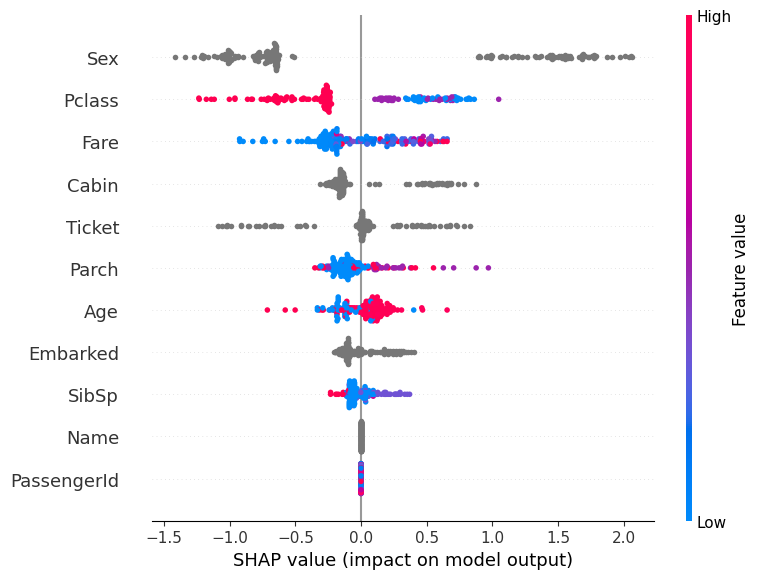

In [111]:
# With categorical features color dont apply
shap.summary_plot(shap_values, X_val)

### Model Predictions

There are two ways of making predictions with classifier
* predict method gives class values either 0 or 1, with decision border 0.5, which is not the best solution at most cases
* predict probability to have ability to select custom border 

In [112]:
clf = CatBoostClassifier(iterations= 136, learning_rate=  0.039393, )
clf.fit(train_pool, verbose=50,)

0:	learn: 0.6778292	total: 11.8ms	remaining: 1.59s
50:	learn: 0.4480807	total: 1.13s	remaining: 1.89s
100:	learn: 0.4049311	total: 2.63s	remaining: 913ms
135:	learn: 0.3899534	total: 3.62s	remaining: 0us


In [113]:
predictions = clf.predict(X_val)
print(predictions[:10]) # calculates sigmoid on top of raw vals, with decision boundary 0.5

[1 0 1 0 1 1 1 1 0 0]


In [114]:
prob_predictions = clf.predict_proba(X_val)
print(prob_predictions[:10])

[[0.0660751  0.9339249 ]
 [0.7241404  0.2758596 ]
 [0.37078118 0.62921882]
 [0.51195689 0.48804311]
 [0.37647174 0.62352826]
 [0.47507486 0.52492514]
 [0.4115123  0.5884877 ]
 [0.27141058 0.72858942]
 [0.8817813  0.1182187 ]
 [0.89911897 0.10088103]]


In [115]:
raw_pred = clf.predict(
    X_val,
    prediction_type='RawFormulaVal'
)
#print(raw_pred) # raw prediction values

In [116]:
#this is how classification is done
from numpy import exp

sigmoid = lambda x: 1/ (1+exp(-x))
probabilities = sigmoid(raw_pred)
print(probabilities[:10]) # returns same output as proba_

[0.9339249  0.2758596  0.62921882 0.48804311 0.62352826 0.52492514
 0.5884877  0.72858942 0.1182187  0.10088103]


When evaluating a machine learning model, it is important to consider the rate of false negatives and false positives. These are instances where the model incorrectly predicts the outcome of a sample. In some cases, such as in medical diagnosis or fraud detection, minimizing false negatives or false positives may be crucial. To understand the rate of false negatives or false positives that a model is allowing, it is useful to plot a curve that shows these rates as the threshold for making a prediction is adjusted. This curve, called the Receiver Operating Characteristic (ROC) curve, is a commonly used tool to evaluate a model's performance and select the appropriate threshold for making predictions.

In [117]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve # fase positive
from catboost.utils import get_fnr_curve # false negative

curve = get_roc_curve(clf, validation_pool)
(fpr, tpr, thresholds) = curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

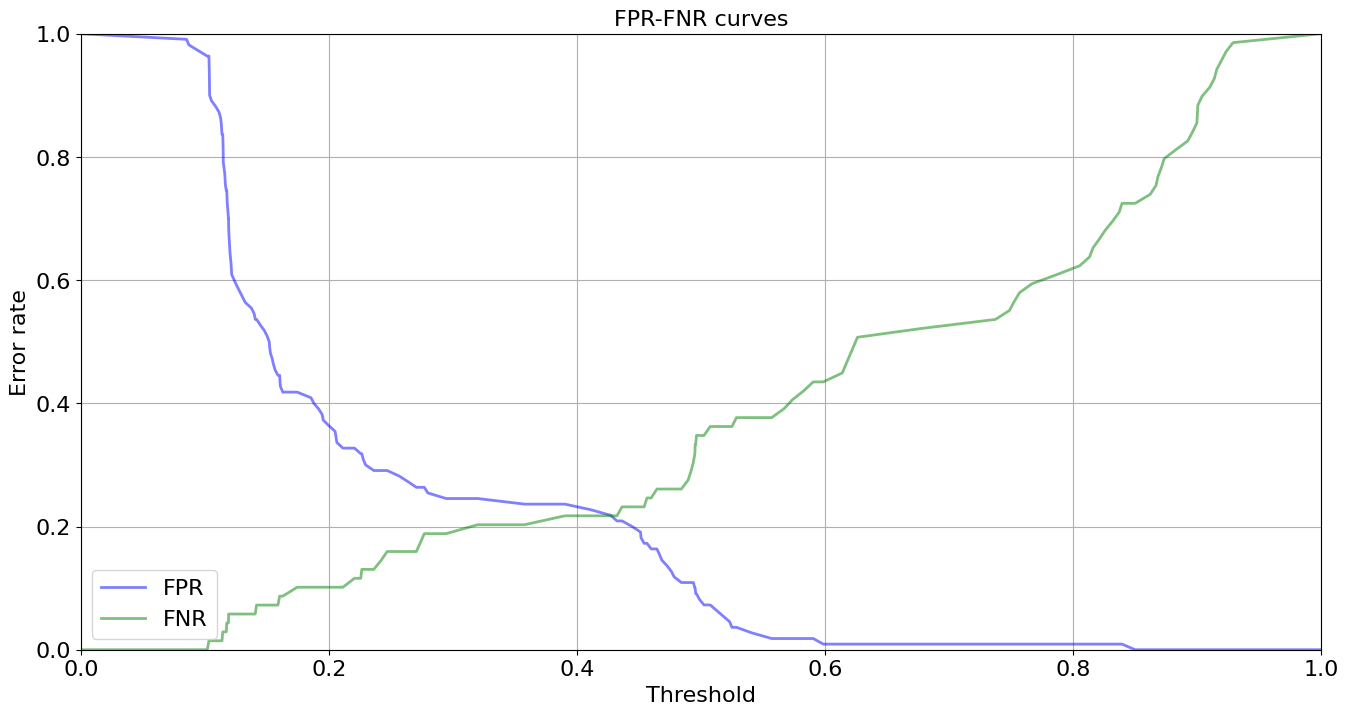

In [118]:
plt.figure(figsize=(16,8))
style = {'alpha': 0.5, 'lw':2}

plt.plot(thresholds, fpr, color='blue', label='FPR', **style)
plt.plot(thresholds, fnr, color='green', label='FNR', **style)

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

Difference in threshold according to false negatives/positives

In [119]:
from catboost.utils import select_threshold

print(select_threshold(clf, validation_pool, FNR=0.01)) #allow no more than 1% of false negatives
print(select_threshold(clf, validation_pool, FPR=0.01)) #allow no more than 1% of false positives

0.10200229691306689
0.5987811819318496


#### Bagging

One way to improve the performance of a machine learning model is to reduce the variance in the predictions. Variance is a measure of how much the predictions of a model can vary for different samples or different training sets. A high variance in predictions can lead to overfitting and poor generalization. One way to reduce the variance is by averaging the predictions from several models that have been trained with different seeds.

A seed is a random number that is used to initialize the random number generator for certain operations such as random sampling or weight initialization. By training multiple models with different seeds, we are creating slightly different versions of the model, each with their own strengths and weaknesses. By averaging the predictions from these models, we are able to reduce the variance and create a more robust model that can generalize better to new data. This technique is known as "bagging" and it is commonly used to improve the performance of machine learning models.

In [120]:
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(estimator=CatBoostClassifier(
                            learning_rate=0.03596672732066315, 
                            iterations=170,
                            l2_leaf_reg=0.003146541249490328,
                            random_strength=0.09639212443611309,
                            bagging_temperature=0.9978679762042104,
                            logging_level='Silent',
                            cat_features=categorical_features_indices
                        ),
                        n_estimators=50, 
                        random_state=0,
                        n_jobs=-1
                        ).fit(train_df, y)


In [121]:
prediction = clf.predict(test_df)
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': prediction})
output.to_csv('data/submission.csv', index=False)

Improvements:

* Adjust classification threshold if necessary 
* Tune bagging technique < 50 est